# Brick element Response

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

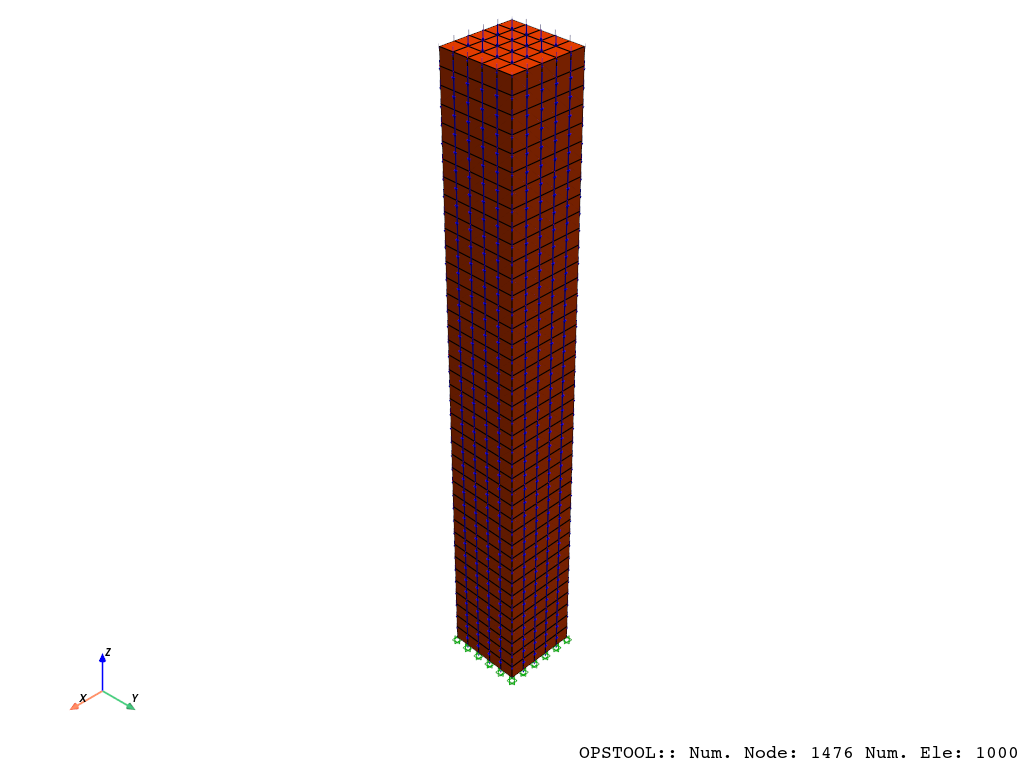

In [2]:
opst.load_ops_examples("Pier-Brick")  # or your model code here

# add beam loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
opst.pre.gen_grav_load(direction="z", factor=-9.81)


# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [4]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Result Reading

In [5]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Solid")

OPSTOOL ::  Loading Solid None response data from _OPSTOOL_ODB/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [6]:
all_resp.data_vars

Data variables:
    Stresses  (time, eleTags, GaussPoints, DOFs) float64 9MB ...
    Strains   (time, eleTags, GaussPoints, DOFs) float64 9MB ...

``Stresses`` and ``Strains`` refer to the stress and strain at the Gauss points. 
Stress and strain consist of six components aligned with the global coordinate system, as well as additional stress measures:

In [7]:
all_resp.DOFs.data

array(['sigma11', 'sigma22', 'sigma33', 'sigma12', 'sigma23', 'sigma13',
       'p1', 'p2', 'p3', 'sigma_vm', 'tau_max', 'sigma_oct', 'tau_oct'],
      dtype='<U9')

In [8]:
all_resp.attrs  # attributes

{'sigma11, sigma22, sigma33': 'Normal stress (strain) along x, y, z.',
 'sigma12, sigma23, sigma13': 'Shear stress (strain).',
 'p1, p2, p3': 'Principal stresses (strains).',
 'sigma_vm': 'Von Mises stress.',
 'tau_max': 'Maximum shear stress (strains).',
 'sigma_oct': 'Octahedral normal stress (strains).',
 'tau_oct': 'Octahedral shear stress (strains).'}

Below, we retrieve the stress and strain data, which is a **4D** array.
The dimensions are, in order, **('time', 'eleTags', 'GaussPoints', 'DOFs')**, and we can conveniently retrieve data based on these dimensions and their coordinates.

In [9]:
stresses = all_resp["Stresses"]
strains = all_resp["Strains"]
print(stresses)
print("=" * 100)
print(strains)
print("=" * 100)
print(stresses.dims)

<xarray.DataArray 'Stresses' (time: 11, eleTags: 1000, GaussPoints: 8, DOFs: 13)> Size: 9MB
[1144000 values with dtype=float64]
Coordinates:
  * eleTags      (eleTags) int32 4kB 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * GaussPoints  (GaussPoints) int32 32B 1 2 3 4 5 6 7 8
  * DOFs         (DOFs) <U9 468B 'sigma11' 'sigma22' ... 'sigma_oct' 'tau_oct'
  * time         (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
<xarray.DataArray 'Strains' (time: 11, eleTags: 1000, GaussPoints: 8, DOFs: 13)> Size: 9MB
[1144000 values with dtype=float64]
Coordinates:
  * eleTags      (eleTags) int32 4kB 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * GaussPoints  (GaussPoints) int32 32B 1 2 3 4 5 6 7 8
  * DOFs         (DOFs) <U9 468B 'sigma11' 'sigma22' ... 'sigma_oct' 'tau_oct'
  * time         (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
('time', 'eleTags', 'GaussPoints', 'DOFs')


In [10]:
stresses2 = stresses.sel(eleTags=1, DOFs="sigma_vm")
strains2 = strains.sel(eleTags=1, DOFs="sigma_vm")
gauss_points = stresses2.coords["GaussPoints"].data

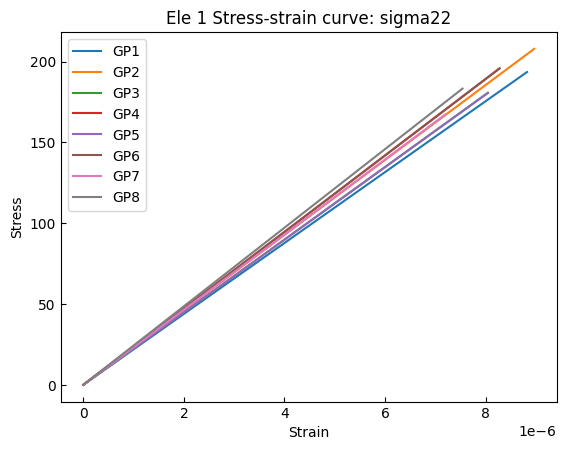

In [11]:
for gp_no in gauss_points:
    s = stresses2.sel(GaussPoints=gp_no)
    d = strains2.sel(GaussPoints=gp_no)
    plt.plot(d, s, label=f"GP{gp_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.legend()
plt.show()

We can also compute averages along a specific dimension. For example, below, we calculate the average stress at the Gauss points:

In [12]:
stresses2 = stresses.sel(DOFs="sigma_vm")
strains2 = strains.sel(DOFs="sigma_vm")
stresses3 = stresses2.mean(dim="GaussPoints")
strains3 = strains2.mean(dim="GaussPoints")

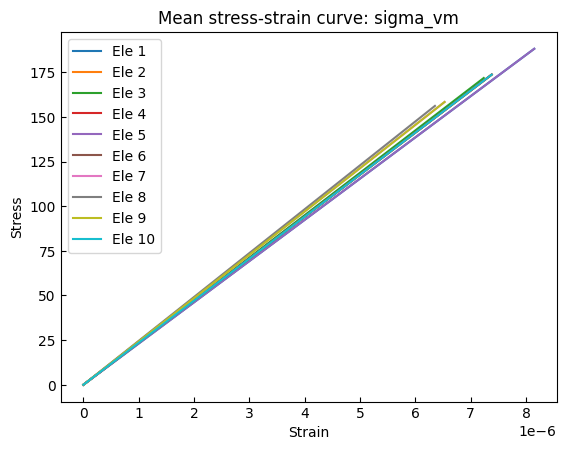

In [13]:
for eletag in np.arange(1, 11):
    s = stresses3.sel(eleTags=eletag)
    d = strains3.sel(eleTags=eletag)
    plt.plot(d, s, label=f"Ele {eletag}")
plt.title("Mean stress-strain curve: sigma_vm")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.legend()
plt.show()